In [1]:
import numpy as np

import typing 
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [2]:
gpu_device = tf.config.list_physical_devices('GPU')
print(gpu_device)

if gpu_device:
    details = tf.config.experimental.get_device_details(gpu_device[0])
print(details)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
{'device_name': 'GeForce MX130', 'compute_capability': (5, 0)}


# Download the dataset

In [3]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', 
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [4]:
text = path_to_file.read_text(encoding='utf-8')
print(len(text))
print(text[:30])

7919056
Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go


In [5]:
lines = text.splitlines()
pairs = [line.split('\t') for line in lines] # get eng-spa paris
context_raw = np.array([c for _, c in pairs])
target_raw = np.array([t for t, _ in pairs])

In [6]:
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [7]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


# Prepare the dataset

In [8]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

In [9]:
train_val_ratio = 0.8
# Uniformly distributed random number array with the length of target_raw
is_train = np.random.uniform(size=(len(target_raw),)) 
print(is_train)
# Pick numbers less than the train_test_ratio
# to get the array of bool values for determining 
# whether include the item in the train set
is_train = is_train < train_val_ratio
print(is_train)

[0.39313443 0.2442707  0.965943   ... 0.08934843 0.45782204 0.35236967]
[ True  True False ...  True  True  True]


In [10]:
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [11]:
for sample_cs, sample_ts in train_raw.take(1):
    print(sample_cs[:5])
    print()
    print(sample_ts[:5])
    print()
    break

tf.Tensor(
[b'M\xc3\xa1ire se cas\xc3\xb3 con el hombre que obtuvo el primer premio.'
 b'Estamos bien.' b'Tom es un excelente jugador.'
 b'Tom ensay\xc3\xb3 por dos d\xc3\xadas.'
 b'En la mayor\xc3\xada de los casos, los accidentes automovil\xc3\xadsticos resultan de la falta de sue\xc3\xb1o.'], shape=(5,), dtype=string)

tf.Tensor(
[b'M\xc3\xa1ire married the man who got first prize.' b"We're OK."
 b'Tom is an outstanding player.' b'Tom rehearsed for two days.'
 b'In most cases, car accidents result from lack of sleep.'], shape=(5,), dtype=string)



# Text Preprocessing

In [12]:
sample_text =tf.constant('¿Todavía está en casa?')
print(sample_text.numpy())
print(sample_text.numpy().decode())

temp_text = tf_text.normalize_utf8(sample_text, 'NFKD')
print(temp_text.numpy())
temp_text = tf.strings.lower(temp_text)
print(temp_text.numpy())
temp_text = tf.strings.regex_replace(temp_text, '[^ a-z.?!,¿]', '')
print(temp_text.numpy())
temp_text = tf.strings.regex_replace(temp_text, '[.?!,¿]', r' \0 ')
print(temp_text.numpy())
temp_text = tf.strings.strip(temp_text)
print(temp_text.numpy())
temp_text = tf.strings.join(['[SOS]', temp_text, '[EOS]'], separator=' ')
print(temp_text.numpy())

print(temp_text.numpy().decode())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
¿Todavía está en casa?
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'
b'\xc2\xbftodavi\xcc\x81a esta\xcc\x81 en casa?'
b'\xc2\xbftodavia esta en casa?'
b' \xc2\xbf todavia esta en casa ? '
b'\xc2\xbf todavia esta en casa ?'
b'[SOS] \xc2\xbf todavia esta en casa ? [EOS]'
[SOS] ¿ todavia esta en casa ? [EOS]


### 1. Standardization

In [13]:
def text_standardize(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    # Lower all letter in the string
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    # Add a start and end token to each sentence
    text = tf.strings.join(['[SOS]', text, '[EOS]'], separator=' ')
    
    return text

In [14]:
print(sample_text.numpy().decode())
print(text_standardize(sample_text).numpy().decode())

¿Todavía está en casa?
[SOS] ¿ todavia esta en casa ? [EOS]


### 2. Create a word index and reverse word index dictionaries

In [15]:
max_vocab_size = 5000

In [16]:
# Spanish TextVectorization layer
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=text_standardize,
    max_tokens=max_vocab_size,
    ragged=True
)
context_text_processor.adapt(train_raw.map(lambda context, target: context))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[SOS]', '[EOS]', '.', 'que', 'de', 'el', 'a', 'no']

In [17]:
# English TextVectorization layer
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=text_standardize,
    max_tokens=max_vocab_size,
    ragged=True
)
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[SOS]', '[EOS]', '.', 'the', 'i', 'to', 'you', 'tom']

In [18]:
sample_cs_tokens = context_text_processor(sample_cs)
sample_cs_tokens[:5, :]

<tf.RaggedTensor [[2, 1, 17, 450, 27, 7, 151, 5, 2424, 7, 678, 1192, 4, 3],
 [2, 170, 76, 4, 3], [2, 10, 15, 16, 1695, 1654, 4, 3],
 [2, 10, 4931, 21, 86, 148, 4, 3],
 [2, 14, 11, 781, 6, 25, 1, 19, 25, 2015, 1, 1, 6, 11, 572, 6, 415, 4, 3]]>

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
for i in range(len(sample_cs[:5])):
    tokens = context_vocab[sample_cs_tokens[i].numpy()]
    print(' '.join(tokens))

[SOS] [UNK] se caso con el hombre que obtuvo el primer premio . [EOS]
[SOS] estamos bien . [EOS]
[SOS] tom es un excelente jugador . [EOS]
[SOS] tom ensayo por dos dias . [EOS]
[SOS] en la mayoria de los [UNK] , los accidentes [UNK] [UNK] de la falta de sueno . [EOS]


Text(0.5, 1.0, 'Mask')

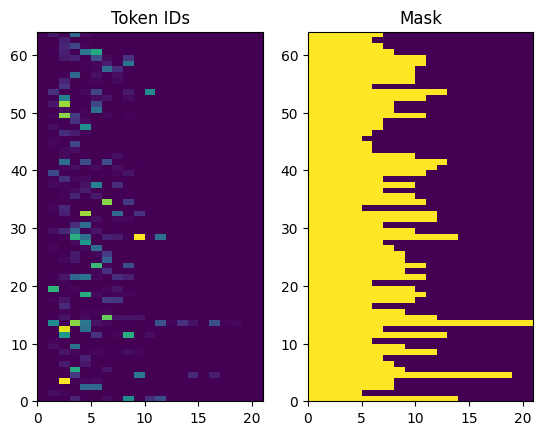

In [20]:
# The returned token IDs are zero-padded
plt.subplot(1, 2, 1)
plt.pcolormesh(sample_cs_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(sample_cs_tokens.to_tensor() != 0)
plt.title('Mask')

### 3. Pad each sentence to a maximum length

In [21]:
# In this example, bidirectional GRU will be used for model training
# Thus, the target are seperated into two set, the forward and backward
# denote as target_in, target_out
# The difference between target_in and target_out is that
# they are shifted by one step relative to eachothe
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    
    return (context, targ_in), targ_out

In [22]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = train_raw.map(process_text, tf.data.AUTOTUNE)

In [23]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :15].numpy()) 
  print()
  print(ex_tar_in[0, :15].numpy()) 
  print(ex_tar_out[0, :15].numpy())

[  2   8  10  28 295  25 770   4   3   0   0   0   0   0   0]

[  2   9 250 818   4   0   0   0   0   0   0   0   0   0   0]
[  9 250 818   4   3   0   0   0   0   0   0   0   0   0   0]


# The Encode-decoder 

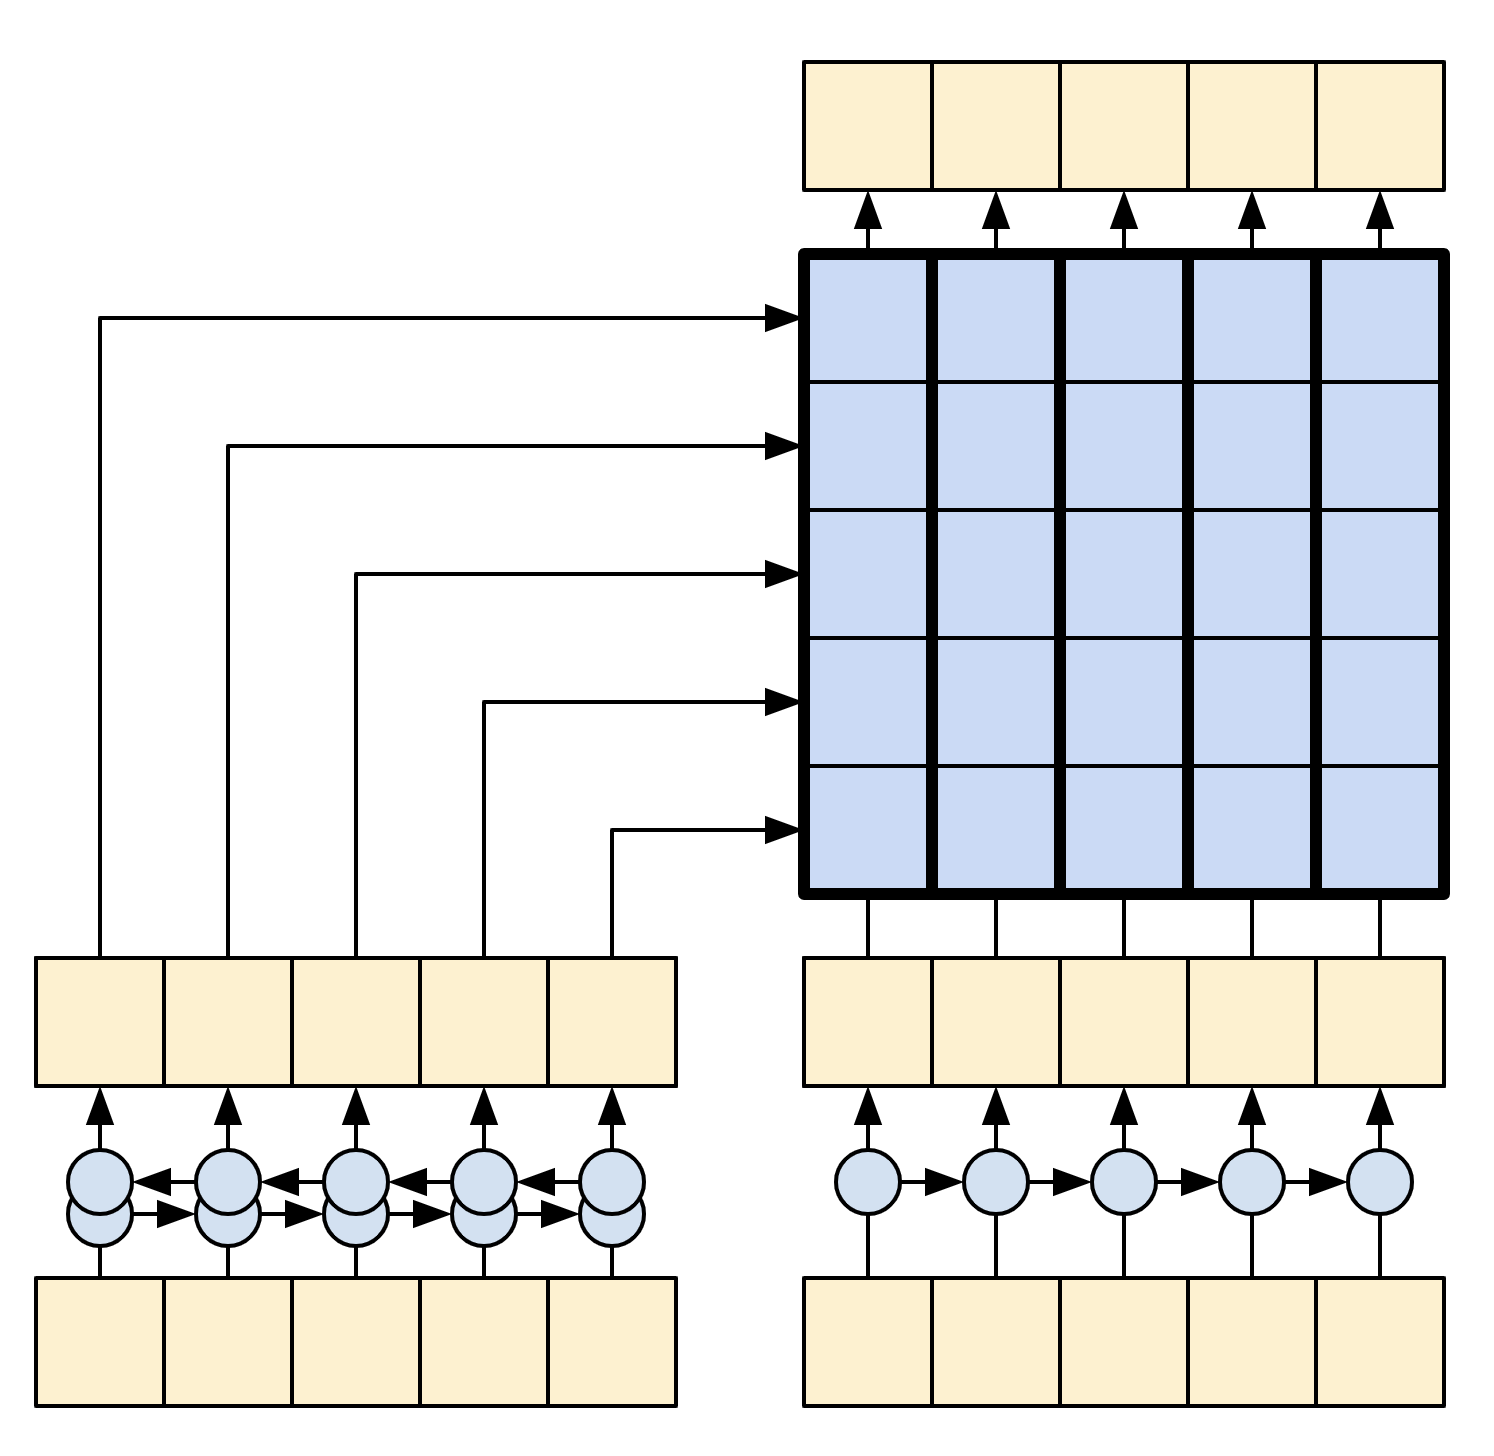

In [24]:
from IPython import display

display.Image('imgs/RNN+attention.png')

In [25]:
UNITS = 256 # Word embedding dimension: a word is represented as a 256-D vector

In [26]:
context_text_processor.vocabulary_size()

5000

In [27]:
# This class is used to check shapes
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

### 1. The encoder: Bidirectional GRU

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units
        
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=units,
            mask_zero=True)
        
        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(
                units=units,
                return_sequences=True, # Return the sequence and state
                recurrent_initializer='glorot_uniform'
            )
        )
    
    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')
        
        # The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')
        
        # The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')
        
        # Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [29]:
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

In [30]:
print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


### 2. The attention layer

In [31]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
    def call(self, x, context):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')
        
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True
        )

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')
        
        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [32]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 18, 256)
Attention result, shape (batch, t, units): (64, 18, 256)
Attention weights, shape (batch, t, s):    (64, 18, 22)


In [33]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.9999999 , 1.        , 1.        , 0.99999994,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 ], dtype=float32)

Text(0.5, 1.0, 'Mask')

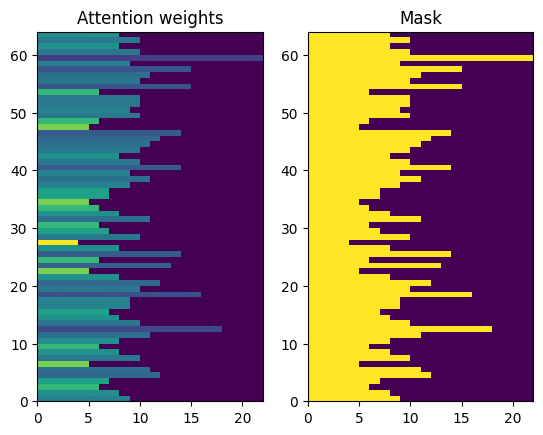

In [34]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask')

### 3. The decoder: Unidirectional GRU

In [35]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        